In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math

In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as T

In [ ]:
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import classification_report

In [3]:
# Define a custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load dataset paths and labels
def load_dataset(data_dir):
    image_paths = []
    labels = []
    class_names = os.listdir(data_dir)
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                image_paths.append(img_path)
                labels.append(class_to_idx[class_name])
    return image_paths, labels

data_dir = '/kaggle/input/chest-dataset/chest_dataset'  # Replace with your dataset path
image_paths, labels = load_dataset(data_dir)

# Split dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)


# Normalization for validation and test
transform_val_test = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = ImageDataset(train_paths, train_labels, transform=transform_train)
val_dataset = ImageDataset(val_paths, val_labels, transform=transform_val_test)
test_dataset = ImageDataset(test_paths, test_labels, transform=transform_val_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
class_namess = os.listdir(data_dir)

In [5]:
class_namess

['pneumonia', 'normal', 'lung_opacity', 'covid']

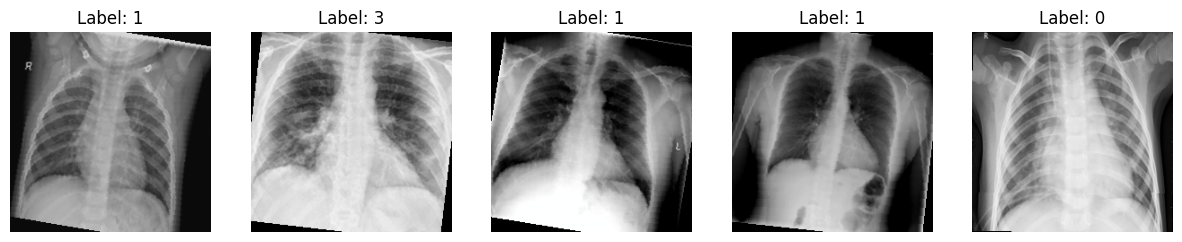

In [6]:
# Verify data loading
def verify_data_loader(data_loader, num_samples=5):
    import matplotlib.pyplot as plt

    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for idx in range(num_samples):
        ax = axes[idx]
        img = images[idx].numpy().transpose(1, 2, 0)
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        ax.imshow(img)
        ax.set_title(f'Label: {labels[idx].item()}')
        ax.axis('off')

    plt.show()

# Verify training data loader
verify_data_loader(train_loader)


In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (batch_size, embed_dim, n_patches**0.5, n_patches**0.5)
        x = x.flatten(2)  # (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (batch_size, n_patches, embed_dim)
        return x

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, n_patches):
        super(PositionalEncoding, self).__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embed

In [9]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

In [10]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=128, depth=12, num_heads=8, mlp_ratio=4.0, num_classes=4):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.pos_embed = PositionalEncoding(embed_dim, self.patch_embed.n_patches)
        
        self.transformer_encoders = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.pos_embed(x)

        for encoder in self.transformer_encoders:
            x = encoder(x)

        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        return x

In [11]:
%%time
# Initialize model, loss function, and optimizer
model = VisionTransformer()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return total_loss / len(test_loader), correct / len(test_loader.dataset)

# Training and evaluation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1, Train Loss: 1.0914, Test Loss: 0.8579, Test Accuracy: 0.6480
Epoch 2, Train Loss: 0.8558, Test Loss: 0.8029, Test Accuracy: 0.6693
Epoch 3, Train Loss: 0.7989, Test Loss: 0.7518, Test Accuracy: 0.7028
Epoch 4, Train Loss: 0.7513, Test Loss: 0.7175, Test Accuracy: 0.7163
Epoch 5, Train Loss: 0.7172, Test Loss: 0.6487, Test Accuracy: 0.7406
Epoch 6, Train Loss: 0.6893, Test Loss: 0.6487, Test Accuracy: 0.7503
Epoch 7, Train Loss: 0.6603, Test Loss: 0.6123, Test Accuracy: 0.7600
Epoch 8, Train Loss: 0.6375, Test Loss: 0.6255, Test Accuracy: 0.7557
Epoch 9, Train Loss: 0.6285, Test Loss: 0.6092, Test Accuracy: 0.7583
Epoch 10, Train Loss: 0.6068, Test Loss: 0.5689, Test Accuracy: 0.7758
Epoch 11, Train Loss: 0.5853, Test Loss: 0.6218, Test Accuracy: 0.7562
Epoch 12, Train Loss: 0.5767, Test Loss: 0.5406, Test Accuracy: 0.7908
Epoch 13, Train Loss: 0.5682, Test Loss: 0.5493, Test Accuracy: 0.7920
Epoch 14, Train Loss: 0.5548, Test Loss: 0.5188, Test Accuracy: 0.8057
Epoch 15, Train